In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
%matplotlib inline

def f(w, w2, x, y):
  p = jnp.dot(jax.nn.tanh(jnp.dot(x, w)), w2)
  return jnp.mean((p - y)**2)


def f_ind(w, w2, x, y):
  #   p = jnp.dot(w2, jax.nn.tanh(jnp.dot(w, x)))
  p = jnp.dot(jax.nn.tanh(jnp.einsum('ncd,nc->nd', w, x)), w2)
  return jnp.mean((p - y)**2, axis=1) / float(y.shape[0])  # [B, 1]


def f_act(w, w2, x, y, dz):
  p = jnp.dot(jax.nn.tanh(jnp.dot(x, w) + dz), w2)
  return jnp.mean((p - y)**2, axis=1) / float(y.shape[0])  # [B, 1]


def grad_perturb_weight(w, v, w2, x, y):

  def f_(w):
    return f(w, w2, x, y)

  _, g = jax.jvp(f_, [w], [v])
  return jnp.sum(g) * v


def grad_perturb_weight_ind(w, v, w2, x, y):

  def f_(w):
    return f_ind(w, w2, x, y)

  _, g = jax.jvp(f_, [jnp.tile(w[None, :, :], [v.shape[0], 1, 1])], [v])
  return jnp.sum(g[:, None, None] * v, axis=0)  # [B, 1, 1] * [B, C, D]


def grad_perturb_act(w, dz, w2, x, y):

  def f_(dz):
    return f_act(w, w2, x, y, dz)

  z = jnp.zeros_like(dz)
  _, g = jax.jvp(f_, [z], [dz])
  return jnp.einsum('nc,nd->cd', x, g[:, None] * dz)


def test_variance_act(N, B, w, w2, w_true, w_true_2):
  grad_fn = jax.grad(f)
  def inner(k):
    key = jax.random.PRNGKey(k)
    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, [B, w.shape[0]])
    y = jnp.dot(jax.nn.tanh(jnp.dot(x, w_true)), w_true_2)
    key, subkey = jax.random.split(key)
    dz = jax.random.normal(subkey, [B, w.shape[1]])
    g = grad_perturb_act(w, dz, w2, x, y)
    g_true = grad_fn(w, w2, x, y)
    return g, g_true
  g_list, g_true_list = jax.vmap(inner)(jnp.arange(N))
  return g_list, g_true_list


def test_variance_weight(N, B, w, w2, w_true, w_true_2):
  grad_fn = jax.grad(f)
  def inner(k):
    key = jax.random.PRNGKey(k)
    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, [B, w.shape[0]])
    y = jnp.dot(jax.nn.tanh(jnp.dot(x, w_true)), w_true_2)
    key, subkey = jax.random.split(key)
    dw = jax.random.normal(subkey, [w.shape[0], w.shape[1]])
    g = grad_perturb_weight(w, dw, w2, x, y)
    g_true = grad_fn(w, w2, x, y)
    return g, g_true
  g_list, g_true_list = jax.vmap(inner)(jnp.arange(N))
  return g_list, g_true_list


def test_variance_weight_ind(N, B, w, w2, w_true, w_true_2):
  grad_fn = jax.grad(f)
  def inner(k):
    key = jax.random.PRNGKey(k)
    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, [B, w.shape[0]])
    y = jnp.dot(jax.nn.tanh(jnp.dot(x, w_true)), w_true_2)
    key, subkey = jax.random.split(key)
    dw = jax.random.normal(subkey, [B, w.shape[0], w.shape[1]])
    g = grad_perturb_weight_ind(w, dw, w2, x, y)
    g_true = grad_fn(w, w2, x, y)
    return g, g_true
  g_list, g_true_list = jax.vmap(inner)(jnp.arange(N))
  return g_list, g_true_list


In [9]:
def run_one_true(N,B,p,q,test_fn,seed=0):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    w1 = jax.random.normal(subkey, [p, q])
    key, subkey = jax.random.split(key)
    key, subkey = jax.random.split(key)
    w2 = jax.random.normal(subkey, [q, 1])
    key, subkey = jax.random.split(key)
    w1_true = jax.random.normal(subkey, [p, q])
    key, subkey = jax.random.split(key)
    w2_true = jax.random.normal(subkey, [q, 1])
    g_list, g_true_list = test_fn(N, B, w1, w2, w1_true, w2_true)
    mean_grad_true = jnp.mean(g_true_list, axis=0)
    g_list, g_true_list = test_fn(N, B, w1, w2, w1_true, w2_true)
    var_true_list = jnp.cumsum((g_true_list - mean_grad_true[None, :, :]) **2, axis=0) / (jnp.arange(N).astype(jnp.float32) + 1.0)[:, None, None]
    mvar_true = jnp.mean(var_true_list, axis=[-1, -2])
    gradsq_true = jnp.mean(mean_grad_true**2, axis=[-1, -2])
    return gradsq_true, mvar_true[-1]

In [13]:
def run_one(N,B,p,q,test_fn,seed=0):
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    w1 = jax.random.normal(subkey, [p, q])
    key, subkey = jax.random.split(key)
    key, subkey = jax.random.split(key)
    w2 = jax.random.normal(subkey, [q, 1])
    key, subkey = jax.random.split(key)
    w1_true = jax.random.normal(subkey, [p, q])
    key, subkey = jax.random.split(key)
    w2_true = jax.random.normal(subkey, [q, 1])
    g_list, g_true_list = test_fn(N, B, w1, w2, w1_true, w2_true)
    mean_grad = jnp.mean(g_list, axis=0)
    mean_grad_true = jnp.mean(g_true_list, axis=0)
    mean_list = jnp.cumsum(g_list, axis=0) / (jnp.arange(N).astype(jnp.float32) + 1)[:, None, None]
    var_true_list = jnp.cumsum((g_list - mean_grad_true[None, :, :]) **2, axis=0) / (jnp.arange(N).astype(jnp.float32) + 1.0)[:, None, None]
    var_list = jnp.cumsum((g_list - mean_grad[None, :, :]) **2, axis=0) / (jnp.arange(N).astype(jnp.float32))[:, None, None]
    mse = jnp.mean((mean_list - mean_grad)**2, axis=[-1, -2])
    mse_true = jnp.mean((mean_list - mean_grad_true)**2, axis=[-1, -2])
    mvar = jnp.mean(var_list, axis=[-1, -2])
    mvar_true = jnp.mean(var_true_list, axis=[-1, -2])
    return mvar_true[-1]

In [18]:
p = 4
q = 4
N = 5000
b_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
blistf = jnp.array(b_list).astype(jnp.float32)

vwt_list = []
gsq_list = []
for B in b_list:
    gsq, gv = run_one_true(5000,B,4,4,test_variance_weight)
    vwt_list.append(gv)
    gsq_list.append(gsq)

vwt_theory = vwt_list[0] / jnp.array(blistf).astype(jnp.float32)
v_theory = vwt_list[0] / jnp.array(blistf).astype(jnp.float32) * (q+2) + (q+1) / blistf * gsq_list[0]
vw_theory = vwt_list[0] / jnp.array(blistf).astype(jnp.float32) * (p*q+2) + (p*q+1) * gsq_list[0]
vwi_theory = vwt_list[0] / jnp.array(blistf).astype(jnp.float32) * (p*q+2) + (p*q+1) / blistf * gsq_list[0]

v_list = []
vw_list = []
vwi_list = []
for B in b_list:
    vw_list.append(run_one(N,B,p,q,test_variance_weight))
for B in b_list:
    vwi_list.append(run_one(N,B,p,q,test_variance_weight_ind))
for B in b_list:
    v_list.append(run_one(N,B,p,q,test_variance_act))

In [20]:
B = 4
p = 4
N = 5000
R = 100
vwt_list2 = []
gsq_list2 = []
q_list = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for run_i in range(R):
    vwt_list2.append([])
    gsq_list2.append([])
    for q in q_list:
        gsq, gv = run_one_true(5000,B,p,q,test_variance_act,seed=run_i)
        vwt_list2[run_i].append(gv)
        gsq_list2[run_i].append(gsq)

qlistf = jnp.array(q_list).astype(jnp.float32)
vwt_list2 = jnp.mean(jnp.array(vwt_list2), axis=0)
gsq_list2 = jnp.mean(jnp.array(gsq_list2), axis=0)
v_theory2 = vwt_list2 * (qlistf+2) + (qlistf+1) / float(B) * gsq_list2
vw_theory2 = vwt_list2 * (qlistf*p+2) + (qlistf*p+1) * gsq_list2
vwi_theory2 = vwt_list2 * (qlistf*p+2) + (qlistf*p+1) / float(B) * gsq_list2

v_list2 = []
vw_list2 = []
vwi_list2 = []
for run_i in range(R):
    v_list2.append([])
    for q in q_list:
        v_list2[run_i].append(run_one(N,B,p,q,test_variance_act, seed=run_i))
for run_i in range(R):
    vw_list2.append([])
    for q in q_list:
        vw_list2[run_i].append(run_one(N,B,p,q,test_variance_weight, seed=run_i))
for run_i in range(R):
    vwi_list2.append([])
    for q in q_list:
        vwi_list2[run_i].append(run_one(N,B,p,q,test_variance_weight_ind, seed=run_i))

v_list2 = jnp.mean(jnp.array(v_list2), axis=0)
vw_list2 = jnp.mean(jnp.array(vw_list2), axis=0)
vwi_list2 = jnp.mean(jnp.array(vwi_list2), axis=0)

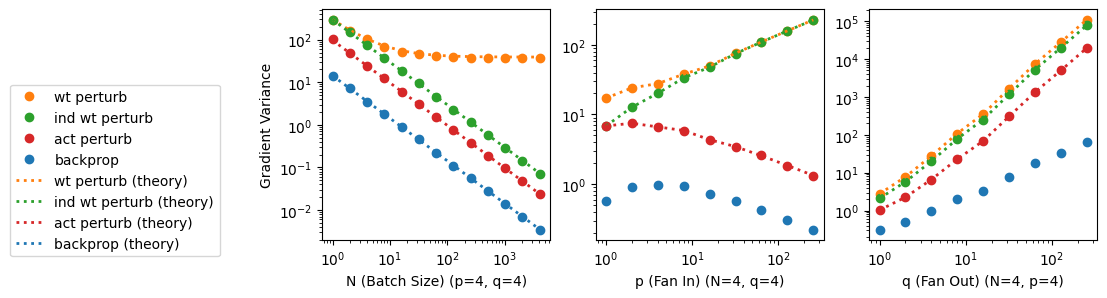

In [22]:
B = 4
q = 4
N = 5000
R = 100
vwt_list3 = []
gsq_list3 = []
p_list = [1, 2, 4, 8, 16, 32, 64, 128, 256]
for run_i in range(R):
    vwt_list3.append([])
    gsq_list3.append([])
    for p in p_list:
        gsq, gv = run_one_true(5000,B,p,q,test_variance_act,seed=run_i)
        vwt_list3[run_i].append(gv)
        gsq_list3[run_i].append(gsq)

v_list3 = []
vw_list3 = []
vwi_list3 = []
plistf = jnp.array(p_list).astype(jnp.float32)
vwt_list3 = jnp.mean(jnp.array(vwt_list3), axis=0)
gsq_list3 = jnp.mean(jnp.array(gsq_list3), axis=0)
v_theory3 = vwt_list3 * (q+2) + (q+1) / float(B) * gsq_list3
vw_theory3 = vwt_list3 * (plistf*q+2) + (plistf*q+1) * gsq_list3
vwi_theory3 = vwt_list3 * (plistf*q+2) + (plistf*q+1) / float(B) * gsq_list3

for run_i in range(R):
    v_list3.append([])
    for p in p_list:
        v_list3[run_i].append(run_one(N,B,p,q,test_variance_act,seed=run_i))

for run_i in range(R):
    vw_list3.append([])
    for p in p_list:
        vw_list3[run_i].append(run_one(N,B,p,q,test_variance_weight,seed=run_i))

for run_i in range(R):
    vwi_list3.append([])
    for p in p_list:
        vwi_list3[run_i].append(run_one(N,B,p,q,test_variance_weight_ind,seed=run_i))

v_list3 = jnp.mean(jnp.array(v_list3), axis=0)
vw_list3 = jnp.mean(jnp.array(vw_list3), axis=0)
vwi_list3 = jnp.mean(jnp.array(vwi_list3), axis=0)

color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
axes[0].loglog(b_list, vw_list, marker='o', linestyle='none', c=color[1], label='wt perturb')
axes[0].loglog(b_list, vwi_list, marker='o', linestyle='none', c=color[2], label='ind wt perturb')
axes[0].loglog(b_list, v_list, marker='o', linestyle='none', c=color[3], label='act perturb')
axes[0].loglog(b_list, vwt_list, marker='o', linestyle='none', c=color[0], label='backprop')
axes[0].loglog(b_list, vw_theory, linestyle='dotted', linewidth=2, c=color[1], label='wt perturb (theory)')
axes[0].loglog(b_list, vwi_theory, linestyle='dotted', linewidth=2, c=color[2], label='ind wt perturb (theory)')
axes[0].loglog(b_list, v_theory, linestyle='dotted', linewidth=2, c=color[3], label='act perturb (theory)')
axes[0].loglog(b_list, vwt_theory, linestyle='dotted', linewidth=2, c=color[0], label='backprop (theory)')
axes[0].set_xlabel('N (Batch Size) (p=4, q=4)')
axes[0].set_ylabel('Gradient Variance')
box = axes[0].get_position()

# Put a legend to the right of the current axis
legend = axes[0].legend(loc='lower left', bbox_to_anchor=(-1.4, -0.1))

axes[1].loglog(p_list, vw_list3, marker='o', linestyle='none', c=color[1], label='wt perturb')
axes[1].loglog(p_list, vwi_list3, marker='o', linestyle='none', c=color[2], label='ind wt perturb')
axes[1].loglog(p_list, v_list3, marker='o', linestyle='none', c=color[3], label='act perturb')
axes[1].loglog(p_list, vwt_list3, marker='o', linestyle='none', c=color[0], label='backprop')
axes[1].loglog(p_list, vw_theory3, linestyle='dotted', linewidth=2, c=color[1], label='wt perturb (theory)')
axes[1].loglog(p_list, vwi_theory3, linestyle='dotted', linewidth=2, c=color[2], label='ind wt perturb (theory)')
axes[1].loglog(p_list, v_theory3, linestyle='dotted', linewidth=2, c=color[3], label='act perturb (theory)')
axes[1].set_xlabel('p (Fan In) (N=4, q=4)')

axes[2].loglog(q_list, vw_list2, marker='o', linestyle='none', c=color[1], label='wt perturb')
axes[2].loglog(q_list, vwi_list2, marker='o', linestyle='none', c=color[2], label='ind wt perturb')
axes[2].loglog(q_list, v_list2, marker='o', linestyle='none', c=color[3], label='act perturb')
axes[2].loglog(q_list, vwt_list2, marker='o', linestyle='none', c=color[0], label='backprop')
axes[2].loglog(q_list, vw_theory2, linestyle='dotted', linewidth=2, c=color[1], label='wt perturb (theory)')
axes[2].loglog(q_list, vwi_theory2, linestyle='dotted', linewidth=2, c=color[2], label='ind wt perturb (theory)')
axes[2].loglog(q_list, v_theory2, linestyle='dotted', linewidth=2, c=color[3], label='act perturb (theory)')
axes[2].set_xlabel('q (Fan Out) (N=4, p=4)')

plt.savefig('variance_theory2.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')